<a href="https://colab.research.google.com/github/Tsinta-Developers/AprendizajeReconocimientodePatrones/blob/main/Tarea2AA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib import colors, patches
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression
from google.colab import files

from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error
try:
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.pipeline import make_pipeline
except ImportError:
    # use backports for sklearn 1.4
    from sklearn_backports import PolynomialFeatures
    from sklearn_backports import make_pipeline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import beta
from scipy import stats
%matplotlib inline


In [ ]:
def fit(Phi, t, alpha_0=1e-5, beta_0=1e-5, max_iter=200, rtol=1e-5, verbose=False):
    """
    Jointly infers the posterior sufficient statistics and optimal values 
    for alpha and beta by maximizing the log marginal likelihood.
    
    Args:
        Phi: Design matrix (N x M).
        t: Target value array (N x 1).
        alpha_0: Initial value for alpha.
        beta_0: Initial value for beta.
        max_iter: Maximum number of iterations.
        rtol: Convergence criterion.
        
    Returns:
        alpha, beta, posterior mean, posterior covariance.
    """
    
    N, M = Phi.shape

    eigenvalues_0 = np.linalg.eigvalsh(Phi.T.dot(Phi))

    beta = beta_0
    alpha = alpha_0

    for i in range(max_iter):
        beta_prev = beta
        alpha_prev = alpha

        eigenvalues = eigenvalues_0 * beta

        m_N, S_N, S_N_inv = posterior(Phi, t, alpha, beta, return_inverse=True)

        gamma = np.sum(eigenvalues / (eigenvalues + alpha))
        alpha = gamma / np.sum(m_N ** 2)

        beta_inv = 1 / (N - gamma) * np.sum((t - Phi.dot(m_N)) ** 2)
        beta = 1 / beta_inv

        if np.isclose(alpha_prev, alpha, rtol=rtol) and np.isclose(beta_prev, beta, rtol=rtol):
            if verbose:
                print(f'Convergence after {i + 1} iterations.')
            return alpha, beta, m_N, S_N

    if verbose:
        print(f'Stopped after {max_iter} iterations.')
    return alpha, beta, m_N, S_N

In [ ]:
def expand(x, bf, bf_args=None):
    if bf_args is None:
        return np.concatenate([np.ones(x.shape), bf(x)], axis=1)
    else:
        return np.concatenate([np.ones(x.shape)] + [bf(x, bf_arg) for bf_arg in bf_args], axis=1)

$y(x,w) = w_0 + w_1x + w_2x^2 + ...+ w_Mx^M = \sum_{j=0}^{M}w_jx^j$

In [ ]:
def polynomial_basis_function(x, power):
    return x ** power

$\frac{1}{\beta_{ML}} = \frac{1}{N} \sum_{n=1}^{N}\{{y(x_n, W_{ML})-t_n}\}^2 $

In [ ]:
def Beta(x,t):
  B = np.empty(len(x))
  for i in range(len(x)):
   B[i] = ((x[i] - t[i])**2)
  Bs = B * (1/len(x)) 
  return Bs

In [ ]:
def posterior(Phi, t, alpha, beta, return_inverse=False):
    """Computes mean and covariance matrix of the posterior distribution."""
    S_N_inv = alpha * np.eye(Phi.shape[1]) + beta * Phi.T.dot(Phi)
    S_N = np.linalg.inv(S_N_inv)
    m_N = beta * S_N.dot(Phi.T).dot(t)

    if return_inverse:
        return m_N, S_N, S_N_inv
    else:
        return m_N, S_N

In [ ]:
def posterior_predictive(Phi_test, m_N, S_N, beta):
    """Computes mean and variances of the posterior predictive distribution."""
    y = Phi_test.dot(m_N)
    # Only compute variances (diagonal elements of covariance matrix)
    y_var = 1 / beta + np.sum(Phi_test.dot(S_N) * Phi_test, axis=1)
    
    return y, y_var

In [ ]:
def func(x): return np.sin(2*np.pi*x)

In [ ]:
def g(X, noise_variance):
    '''Sinusoidal function plus noise'''
    return 0.5 + np.sin(2 * np.pi * X) + noise(X.shape, noise_variance)

In [ ]:
def noise(size, variance):
    return np.random.normal(scale=np.sqrt(variance), size=size)

In [ ]:
def plot_data(x, t):
    plt.scatter(x, t, marker='o', c="k", s=20)


def plot_truth(x, y, label='Truth'):
    plt.plot(x, y, 'k--', label=label)


def plot_predictive(x, y, std, y_label='Prediction', std_label='Uncertainty', plot_xy_labels=True):
    y = y.ravel()
    std = std.ravel()

    plt.plot(x, y, label=y_label)
    plt.fill_between(x.ravel(), y + std, y - std, alpha = 0.1, label=std_label)

    if plot_xy_labels:
        plt.xlabel('x')
        plt.ylabel('y')

def plot_posterior_samples(x, ys, plot_xy_labels=True):
    plt.plot(x, ys[:, 0], 'r-', alpha=0.5, label='Post. samples')
    for i in range(1, ys.shape[1]):
        plt.plot(x, ys[:, i], 'r-', alpha=0.5)

    if plot_xy_labels:
        plt.xlabel('x')
        plt.ylabel('y')


def plot_posterior(mean, cov, w0, w1):
    resolution = 100

    grid_x = grid_y = np.linspace(-1, 1, resolution)
    grid_flat = np.dstack(np.meshgrid(grid_x, grid_y)).reshape(-1, 2)

    densities = stats.multivariate_normal.pdf(grid_flat, mean=mean.ravel(), cov=cov).reshape(resolution, resolution)
    plt.imshow(densities, origin='lower', extent=(-1, 1, -1, 1))
    plt.scatter(w0, w1, marker='x', c="r", s=20, label='Truth')

    plt.xlabel('w0')
    plt.ylabel('w1')


def print_comparison(title, a, b, a_prefix='np', b_prefix='br'):
    print(title)
    print('-' * len(title))
    print(f'{a_prefix}:', a)
    print(f'{b_prefix}:', b)
    print()

In [ ]:
n_samples = 20
X = np.linspace(0, 1, n_samples)[:, np.newaxis]
y = func(X) + np.random.normal(0,0.1,size=(n_samples))[:, np.newaxis]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
X_train

array([[0.26315789],
       [0.73684211],
       [0.57894737],
       [0.21052632],
       [0.05263158],
       [0.78947368],
       [0.89473684],
       [0.84210526],
       [1.        ],
       [0.36842105]])

In [ ]:
N = 10

Rbeta = 1 / (0.3 ** 2)
alpha = 0.005

degree = 9
degrees = range(degree + 1)

X = np.linspace(0, 1, N).reshape(-1, 1)
X2 = np.linspace(0, 1, N).reshape(-1, 1)
X_test = np.linspace(0, 1, 100).reshape(-1, 1)
t = g(X, noise_variance=1/Rbeta)
t2 = g(X, noise_variance=1/Rbeta)
y_true = g(X_test, noise_variance=0)
Phi_test = expand(X_test, bf=polynomial_basis_function, bf_args=degrees[1:])
Phi = expand(X, bf=polynomial_basis_function, bf_args=range(1, degree + 1))

wmls = polynomial_basis_function(X,degrees[1:])
Be = Beta(np.sum(wmls,axis=1),t)
Bml = np.sum(Be)

a, beta, m_N, S_N = fit(Phi, t)
Bml

11.979185912746782

In [ ]:
np.sum(wmls,axis=1), X, wmls

(array([0.        , 0.125     , 0.28571391, 0.4999746 , 0.79945869,
        1.2436983 , 1.94797541, 3.135441  , 5.22848467, 9.        ]),
 array([[0.        ],
        [0.11111111],
        [0.22222222],
        [0.33333333],
        [0.44444444],
        [0.55555556],
        [0.66666667],
        [0.77777778],
        [0.88888889],
        [1.        ]]),
 array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        [1.11111111e-01, 1.23456790e-02, 1.37174211e-03, 1.52415790e-04,
         1.69350878e-05, 1.88167642e-06, 2.09075158e-07, 2.32305731e-08,
         2.58117479e-09],
        [2.22222222e-01, 4.93827160e-02, 1.09739369e-02, 2.43865264e-03,
         5.41922810e-04, 1.20427291e-04, 2.67616202e-05, 5.94702672e-06,
         1.32156149e-06],
        [3.33333333e-01, 1.11111111e-01, 3.70370370e-02, 1.23456790e-02,
         4.11522634e-03, 1.37174211e-03, 4.57247371

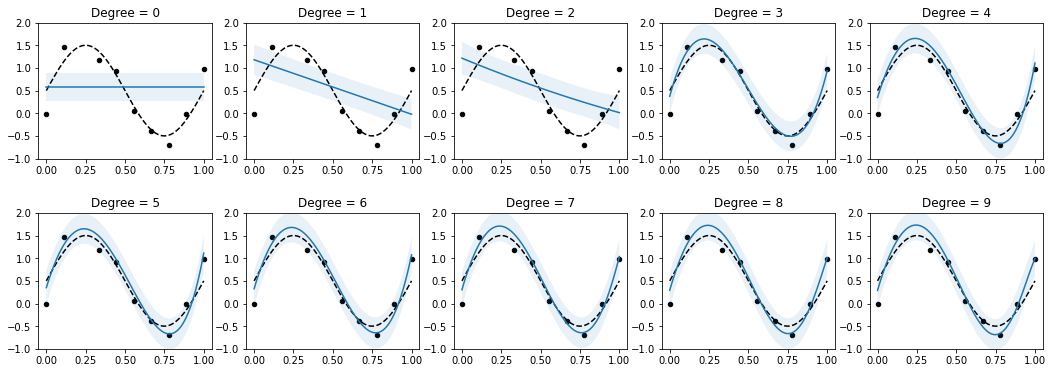

In [ ]:
%matplotlib inline
plt.figure(figsize=(18, 6))
plt.subplots_adjust(hspace=0.4)

for d in degrees:
    up = d + 1
    m_N, S_N, S_Ninv = posterior(Phi[:,:up], t, alpha, Bml, return_inverse=True)
    y_train_P, y_var = posterior_predictive(Phi_test[:,:up], m_N, S_N, Bml)

    plt.subplot(2, 5, up)
    plot_data(X, t)
    plot_truth(X_test, y_true, label=None)
    plot_predictive(X_test, y_train_P, np.sqrt(y_var), y_label=None, std_label=None, plot_xy_labels=False)
    plt.title(f'Degree = {d}')
    plt.ylim(-1.0, 2.0)

In [ ]:
 S_Ninv

array([[119.79685913,  59.89592956,  42.14898747,  33.27551642,
         27.99525341,  24.5115944 ,  22.05417985,  20.23782996,
         18.84850254,  17.75772418],
       [ 59.89592956,  42.15398747,  33.27551642,  27.99525341,
         24.5115944 ,  22.05417985,  20.23782996,  18.84850254,
         17.75772418,  16.88369821],
       [ 42.14898747,  33.27551642,  28.00025341,  24.5115944 ,
         22.05417985,  20.23782996,  18.84850254,  17.75772418,
         16.88369821,  16.17185867],
       [ 33.27551642,  27.99525341,  24.5115944 ,  22.05917985,
         20.23782996,  18.84850254,  17.75772418,  16.88369821,
         16.17185867,  15.58439956],
       [ 27.99525341,  24.5115944 ,  22.05417985,  20.23782996,
         18.85350254,  17.75772418,  16.88369821,  16.17185867,
         15.58439956,  15.09429179],
       [ 24.5115944 ,  22.05417985,  20.23782996,  18.84850254,
         17.75772418,  16.88869821,  16.17185867,  15.58439956,
         15.09429179,  14.68169346],
       [ 2

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

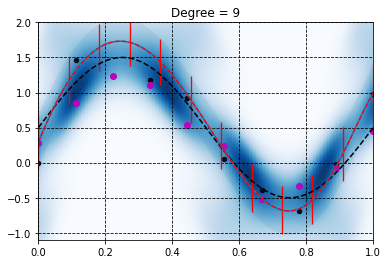

In [ ]:
import seaborn as sns

# Need an (N, 2) array of (x, y) pairs.

m_N, S_N = posterior(Phi, t, alpha,Bml)
y_train_P, y_var = posterior_predictive(Phi_test, m_N, S_N,Bml)

data = np.vstack([y_true.flat,X_test.flat])
kde = gaussian_kde(data)

Xmesh, Ymesh = np.meshgrid(y_train_P,X_test)
Z = kde.evaluate(np.vstack([Xmesh.ravel(), Ymesh.ravel()]))

plot_data(X, t)
plt.scatter(X2, t2,color='m')
plot_truth(X_test, y_true, label=None)
plot_predictive(X_test, y_train_P, np.sqrt(y_var), y_label=None, std_label=None, plot_xy_labels=False)
plt.imshow(Z.reshape(Xmesh.shape), aspect='auto',extent=[0.0, 1.0, -1.1, 2.0],cmap='Blues')
plt.errorbar(X_test,y_train_P,np.sqrt(y_var), color='red',label="Error",linewidth=1.3,errorevery=9,fmt='--')
plt.title(f'Degree = {9}')
plt.rc('grid', linestyle="--", color='black')
plt.grid(True)
plt.xlim(0.0,1.0)
plt.ylim(-1.1, 2.0)
plt.savefig("1.png",dpi=600)
files.download("1.png")